In [34]:
# predict customer complaints

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

In [4]:
# load the dataset
df = pd.read_csv('/content/weekly_customer_complaints.csv',
                 index_col='week'
                 ,parse_dates=True)
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,"1,750",37.26%,1,0,0
2018-01-08,"1,701",35.38%,0,0,0
2018-01-15,"1,711",36.22%,1,0,0
2018-01-22,"1,443",38.33%,1,0,0
2018-01-29,"1,397",36.34%,0,0,0


In [5]:
# Preview df
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2018-01-01 to 2022-12-26
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaints               261 non-null    object
 1   discount_rate            261 non-null    object
 2   small_commercial_event   261 non-null    int64 
 3   medium_commercial_event  261 non-null    int64 
 4   big_commercial_event     261 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 12.2+ KB


In [6]:
# Convert "Date" to a datetime object
df = df.rename(columns={'complaints': 'y'})

In [7]:
df.head()

,y,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,"1,750",37.26%,1,0,0
2018-01-08,"1,701",35.38%,0,0,0
2018-01-15,"1,711",36.22%,1,0,0
2018-01-22,"1,443",38.33%,1,0,0
2018-01-29,"1,397",36.34%,0,0,0


In [8]:
# remove the comma from df.y and transform into an integer
df["y"]= df["y"].str.replace(",","").astype(int)
df.head()

,y,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,1750,37.26%,1,0,0
2018-01-08,1701,35.38%,0,0,0
2018-01-15,1711,36.22%,1,0,0
2018-01-22,1443,38.33%,1,0,0
2018-01-29,1397,36.34%,0,0,0


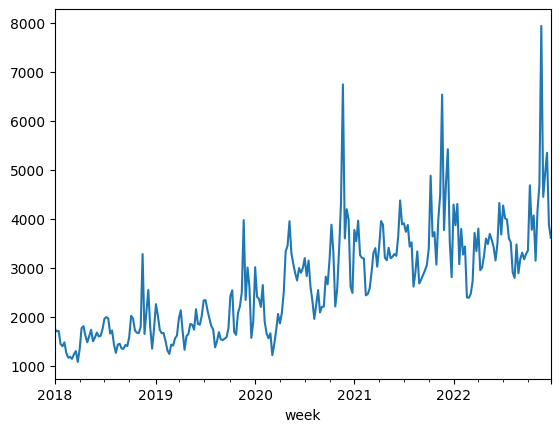

In [9]:
df['y'].plot()
plt.show()

# Seasonality

/tmp/ipython-input-3083763.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_plot(df['y'].resample('M').mean(), ylabel = 'Closing') # M is monthly


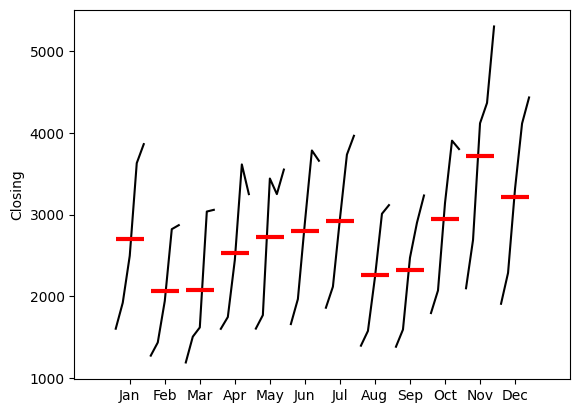

In [10]:
# Monthly seasonality
month_plot(df['y'].resample('M').mean(), ylabel = 'Closing') # M is monthly
plt.show()

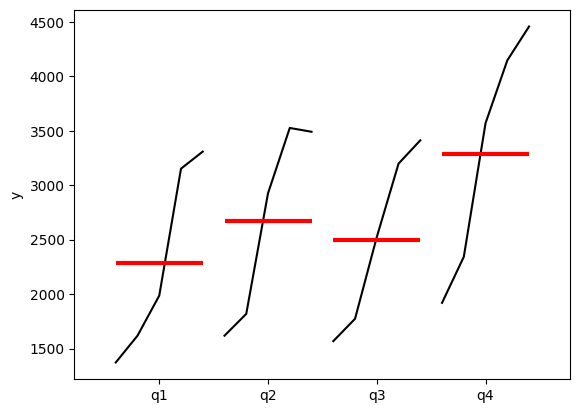

In [11]:
# Quarter plot
quarter_plot(df['y'].resample('QE').mean(), ylabel = 'y') # quarter end
plt.show()

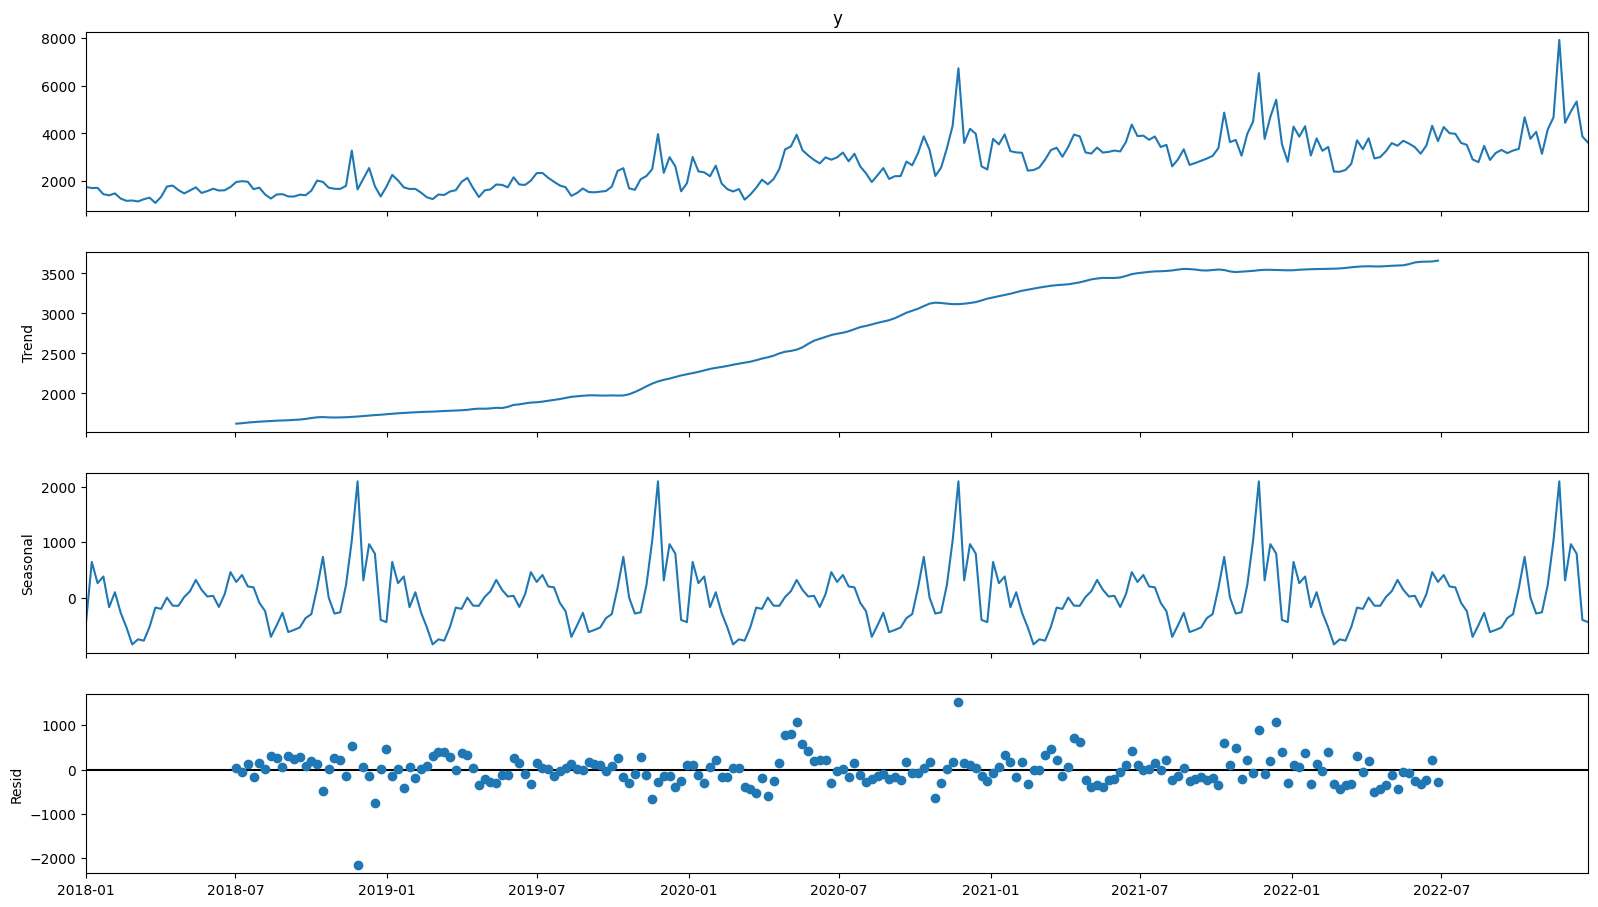

In [12]:
# seasonal decomposition for df['Close']
decomposition = seasonal_decompose(df['y']
                                   , model = 'additive'
                                   , period = 52)
fig=decomposition.plot()
fig.set_size_inches(18,10)
plt.show()

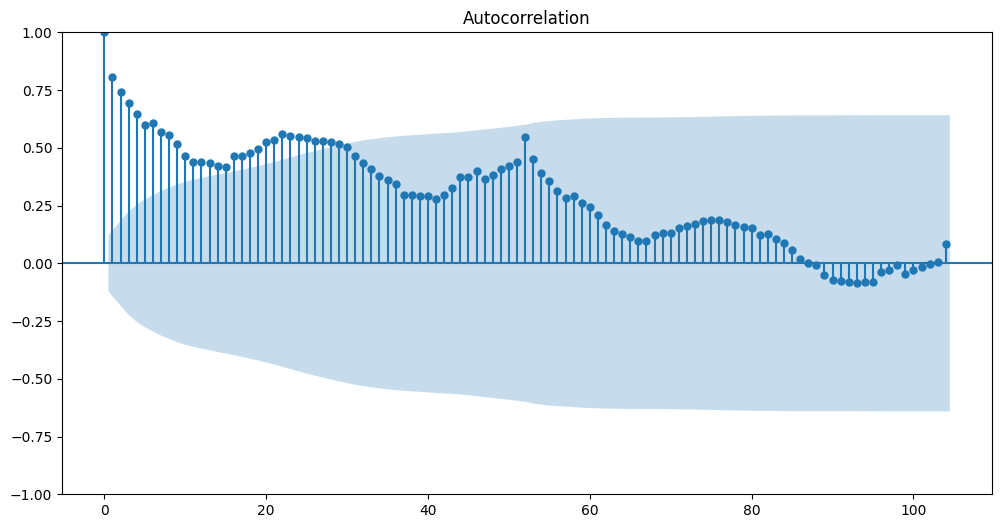

In [13]:
# Plot the ACF - autocorelation of y
fig, ax = plt.subplots(figsize = (12, 6))
plot_acf(df['y'], lags = 104, ax = ax)
plt.show()

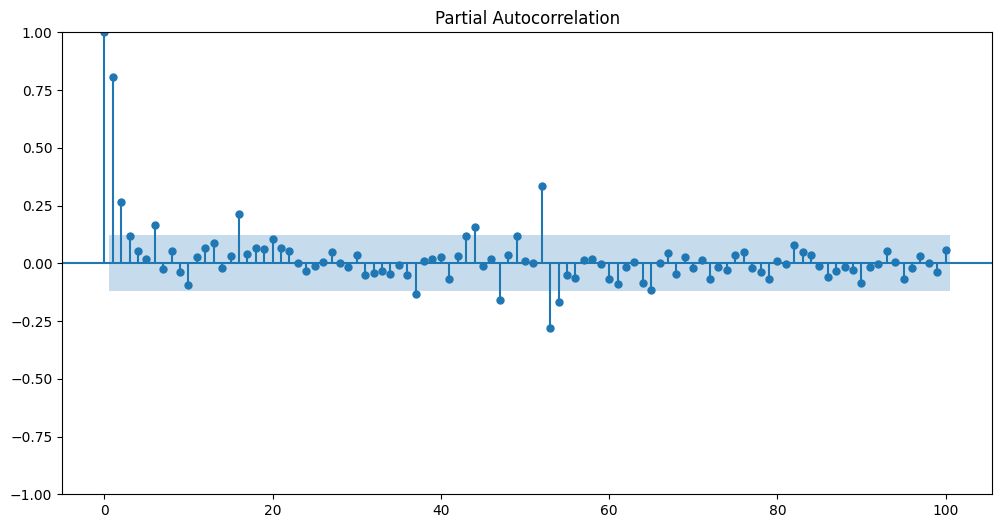

In [14]:

# PACF for y  (the higher the bar, the more relevance)
fig, ax = plt.subplots(figsize = (12, 6))
plot_pacf(df['y'], lags = 100, ax = ax)
plt.show()

Time Series Frequency

In [15]:
# print the frequency of time series
df.index

DatetimeIndex(['2018-01-01', '2018-01-08', '2018-01-15', '2018-01-22',
               '2018-01-29', '2018-02-05', '2018-02-12', '2018-02-19',
               '2018-02-26', '2018-03-05',
               ...
               '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14',
               '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12',
               '2022-12-19', '2022-12-26'],
              dtype='datetime64[ns]', name='week', length=261, freq=None)

In [16]:
# Change the frequency to W-Mon
df = df.asfreq('W-Mon')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2018-01-01 to 2022-12-26
Freq: W-MON
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   y                        261 non-null    int64 
 1   discount_rate            261 non-null    object
 2   small_commercial_event   261 non-null    int64 
 3   medium_commercial_event  261 non-null    int64 
 4   big_commercial_event     261 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 12.2+ KB


# Training and Test

# Goal: predict the next 13 weeks

In [17]:
# split the data into training and test
periods = 13
train = df[:-periods].y
test = df[-periods:].y

In [26]:
train.tail()

,y
week,
2022-08-29,2885
2022-09-05,3177
2022-09-12,3306
2022-09-19,3170
2022-09-26,3279


In [18]:
# other way to split data
train, test = df.iloc[:-periods, 0], df.iloc[-periods:,0]

# Simple exponential smoothing

In [19]:
# Apply SES to the train
ses_model = SimpleExpSmoothing(train).fit()
print(ses_model.summary())
# smoothing level is taking % from previous prediction

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                      y   No. Observations:                  248
Model:             SimpleExpSmoothing   SSE                       74355478.081
Optimized:                       True   AIC                           3131.513
Trend:                           None   BIC                           3138.540
Seasonal:                        None   AICC                          3131.678
Seasonal Periods:                None   Date:                 Thu, 25 Sep 2025
Box-Cox:                        False   Time:                         01:32:17
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5097819                alpha                 True
initial_level              1750.0000                

In [20]:
# compute with the initial level
train.iloc[-1]*0.51 +1750

np.float64(3422.29)

In [21]:
# Predictions
ses_pred = ses_model.forecast(periods)
ses_pred

,0
2022-10-03,3236.663473
2022-10-10,3236.663473
2022-10-17,3236.663473
2022-10-24,3236.663473
2022-10-31,3236.663473
2022-11-07,3236.663473
2022-11-14,3236.663473
2022-11-21,3236.663473
2022-11-28,3236.663473
2022-12-05,3236.663473


In [44]:
#train.loc['2021']

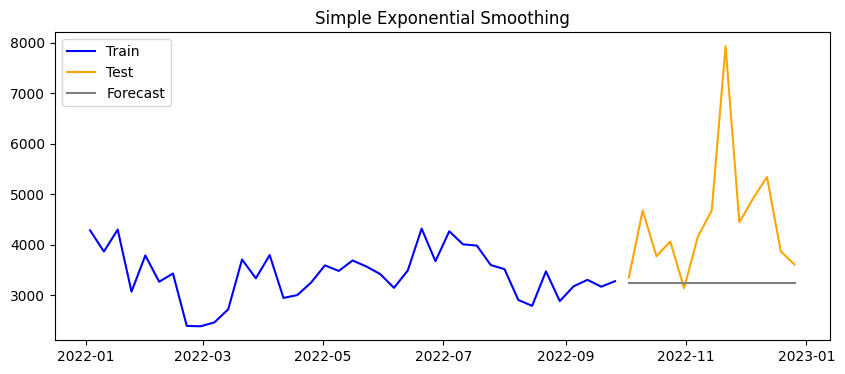

In [22]:
# Set the size of the plot of 10 by 4
plt.figure(figsize = (10,4))

# plot the train, test and forecast data
plt.plot( train.loc['2022'], label = 'Train', color = 'blue')
plt.plot(test, label = 'Test', color= 'orange')
plt.plot(ses_pred, label = 'Forecast', color='grey')

plt.title('Simple Exponential Smoothing')
plt.legend()
plt.show()

# Double Exponential Smoothing

In [25]:
# Build double exponential smoothing model
model_double = ExponentialSmoothing(train
                                    , trend = 'add'
                                    , seasonal = None).fit()
print(model_double.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                        y   No. Observations:                  248
Model:             ExponentialSmoothing   SSE                       74343958.374
Optimized:                         True   AIC                           3135.474
Trend:                         Additive   BIC                           3149.528
Seasonal:                          None   AICC                          3135.823
Seasonal Periods:                  None   Date:                 Thu, 25 Sep 2025
Box-Cox:                          False   Time:                         01:34:35
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5093872                alpha                 True
smoothing_trend             0.0000

In [26]:
# Predict with the double ES model
double_pred = model_double.forecast(periods)
double_pred

,0
2022-10-03,3248.184263
2022-10-10,3254.072668
2022-10-17,3259.961074
2022-10-24,3265.849480
2022-10-31,3271.737885
2022-11-07,3277.626291
2022-11-14,3283.514697
2022-11-21,3289.403102
2022-11-28,3295.291508
2022-12-05,3301.179913


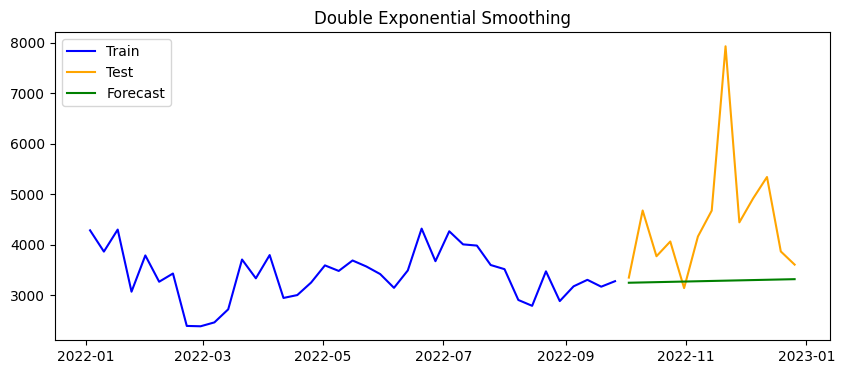

In [30]:
# plot the train, test and forecast
plt.figure(figsize = (10,4))
plt.plot( train.loc['2022'], label = 'Train', color = 'blue')
plt.plot(test, label = 'Test', color= 'orange')
plt.plot(double_pred, label = 'Forecast', color='green')
plt.title('Double Exponential Smoothing')
plt.legend()
plt.show()

# Triple Exponential Smoothing aka Holt-Winters

In [38]:
# Build the Holt-Winters Model
model_holt = ExponentialSmoothing(train
                                  , trend = 'mul'
                                  , seasonal = 'mul'
                                  , seasonal_periods = 52).fit()
print(model_holt.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                        y   No. Observations:                  248
Model:             ExponentialSmoothing   SSE                       21601472.986
Optimized:                         True   AIC                           2932.961
Trend:                   Multiplicative   BIC                           3129.713
Seasonal:                Multiplicative   AICC                          2969.173
Seasonal Periods:                    52   Date:                 Thu, 25 Sep 2025
Box-Cox:                          False   Time:                         02:29:03
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2517327                alpha                 True
smoothing_trend          

In [40]:
# Predict with the Holt-Winters model
holt_pred = model_holt.forecast(periods)
holt_pred

,0
2022-10-03,4056.273947
2022-10-10,5067.514342
2022-10-17,3957.752185
2022-10-24,3558.629819
2022-10-31,3468.242492
2022-11-07,4300.143141
2022-11-14,5404.309802
2022-11-21,7319.519337
2022-11-28,4409.655503
2022-12-05,5382.927578


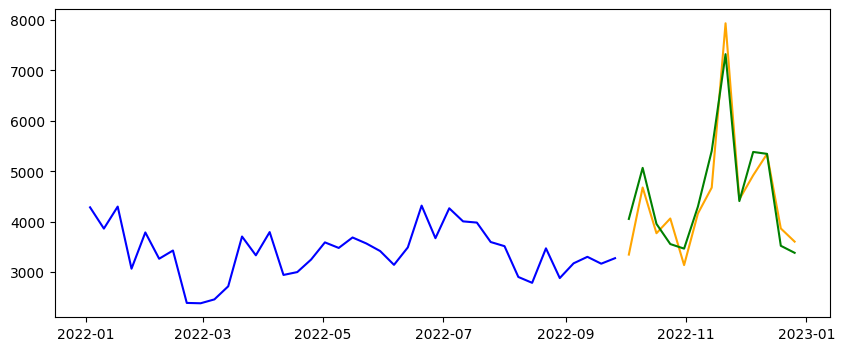

In [42]:
# Plot the Train, Test and Forecast
plt.figure(figsize = (10,4))

# Plot the train, test, forecast
plt.plot(train.loc['2022'], label = 'Train', color = 'blue')
plt.plot(test, label = 'Test', color = 'orange')
plt.plot(holt_pred, label = 'Forecast', color = 'green')

# Measure Accuracy Errors

In [41]:
# Calculate and print the RMSE, MAE, and MAPE
rmse = root_mean_squared_error(test, holt_pred)
mae = mean_absolute_error(test, holt_pred)
mape = mean_absolute_percentage_error(test, holt_pred)
print(f'RMSE: {rmse:.0f}')
print(f'MAE: {mae:.0f}')
print(f'MAPE: {100 * mape:.1f} %')

RMSE: 425
MAE: 358
MAPE: 8.4 %


In [46]:
# Function the assesses the model and visualizes the train, test and forecast
def model_assesssment(train, test, predictions, chart_title=None):
  plt.figure(figsize = (10,4))
  # Plot the train, test and forecast data
  plt.plot(train, label = 'Train', color = 'blue')
  plt.plot(test, label = 'Test', color = 'orange')
  plt.plot(predictions, label = 'Forecast', color = 'green')
  plt.title(chart_title)
  plt.legend()
  plt.show()
  # Calculate and print the RMSE, MAE and MAPE
  rmse = root_mean_squared_error(test, predictions)
  mae = mean_absolute_error(test, predictions)
  mape = mean_absolute_percentage_error(test, predictions)
  print(f'RMSE: {rmse:.0f}')
  print(f'MAE: {mae:.0f}')
  print(f'MAPE: {100 * mape:.1f} %')

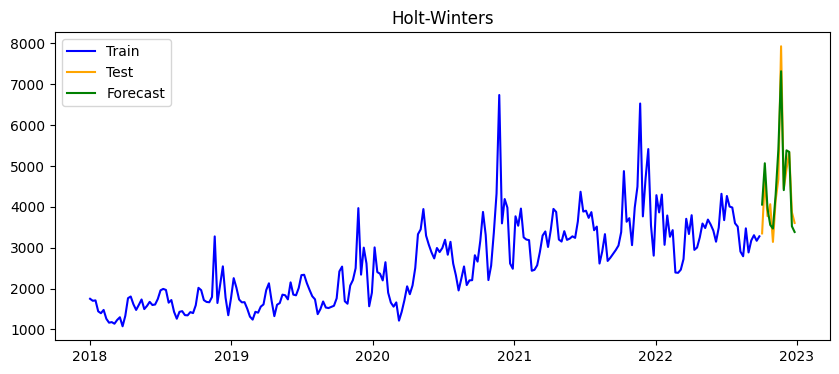

RMSE: 425
MAE: 358
MAPE: 8.4 %


In [47]:
# Apply the function
model_assesssment(train, test, holt_pred, 'Holt-Winters')

# Predict the future

In [49]:
df.head()

,y,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,1750,37.26%,1,0,0
2018-01-08,1701,35.38%,0,0,0
2018-01-15,1711,36.22%,1,0,0
2018-01-22,1443,38.33%,1,0,0
2018-01-29,1397,36.34%,0,0,0


In [48]:
# Build a Holt Winters model with the complete data
model_holt_complete = ExponentialSmoothing(df.y
                                            , trend = 'add'
                                            , seasonal = 'mul'
                                            , seasonal_periods = 52).fit()

RMSE: 425
MAE: 358
MAPE: 8.4 %

In [51]:
# Predict with the model
forecast = model_holt_complete.forecast(13)
forecast[:5]

,0
2023-01-02,4965.837323
2023-01-09,4478.091513
2023-01-16,4699.515551
2023-01-23,3814.120124
2023-01-30,4242.022859


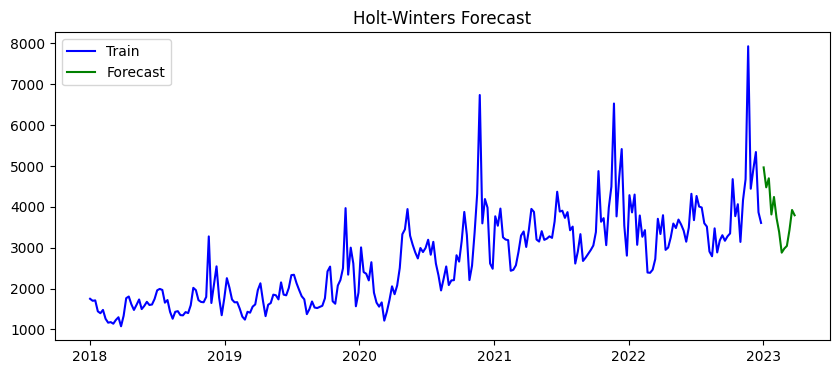

In [53]:
# plot the train, test and forecast
plt.figure(figsize = (10,4))
plt.plot(df.y, label = 'Train', color = 'blue')
plt.plot(forecast, label = 'Forecast', color = 'green')
# Add a tilte and legend to the plot
plt.title('Holt-Winters Forecast')
plt.legend()
plt.show()

In [60]:
# build a chart function
def plot_future(y, forecast, chart_title=None):
  plt.figure(figsize = (10,4))
  plt.plot(y, label = 'Train', color = 'blue')
  plt.plot(forecast, label = 'Forecast', color = 'green')
  plt.title(chart_title)
  plt.legend()
  plt.show()

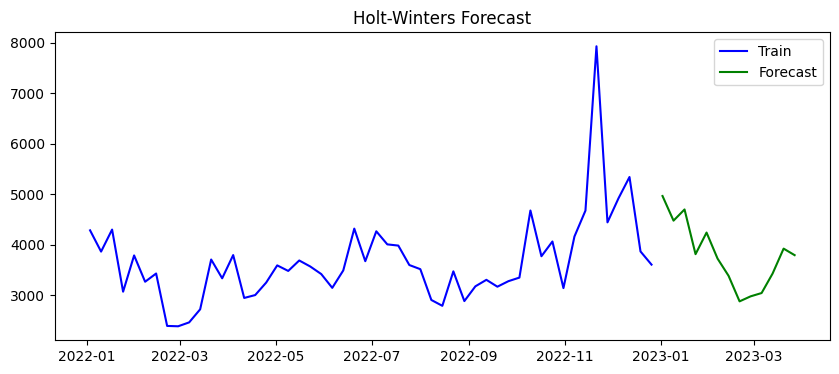

In [61]:
plot_future(df.y.loc["2022"], forecast, 'Holt-Winters Forecast')

# Daily Data

In [84]:
# Load the bitcoin price data

df_daily = pd.read_csv("/content/bitcoin_price.csv",
                       index_col="Date", parse_dates=True)['Adj Close']
df_daily.head()

,Adj Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [81]:
df_daily.index

DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2023-12-21', '2023-12-22', '2023-12-23', '2023-12-24',
               '2023-12-25', '2023-12-26', '2023-12-27', '2023-12-28',
               '2023-12-29', '2023-12-30'],
              dtype='datetime64[ns]', name='Date', length=3392, freq=None)

In [85]:
# Setting the index frequency to daily
df_daily = df_daily.asfreq('D')
df_daily.index

DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2023-12-21', '2023-12-22', '2023-12-23', '2023-12-24',
               '2023-12-25', '2023-12-26', '2023-12-27', '2023-12-28',
               '2023-12-29', '2023-12-30'],
              dtype='datetime64[ns]', name='Date', length=3392, freq='D')

# Model Assessment

In [86]:
# Set the test data to 30 days
periods = 30
train, test = df_daily.iloc[:-periods], df_daily.iloc[-periods:,]

In [87]:
train.tail()

,Adj Close
Date,
2023-11-26,37479.121094
2023-11-27,37254.167969
2023-11-28,37831.085938
2023-11-29,37858.492188
2023-11-30,37712.746094


In [89]:
# Build a holt winters model
model_daily = ExponentialSmoothing(train
                                   , trend = 'mul'
                                   , seasonal = 'mul'
                                   , seasonal_periods = 365).fit()

/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


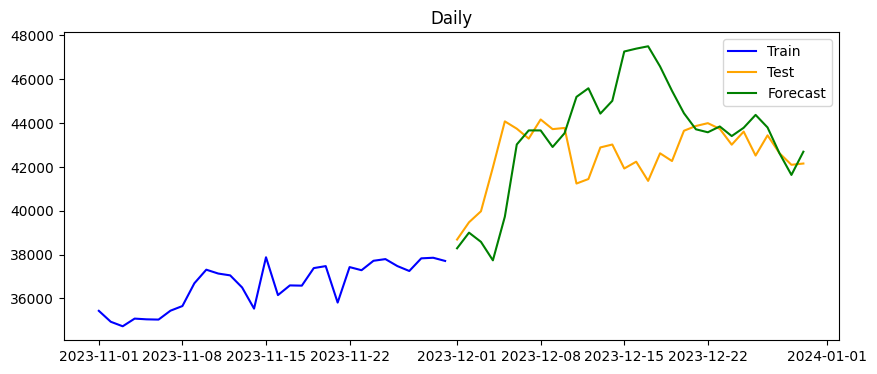

RMSE: 2607
MAE: 1807
MAPE: 4.3 %


In [95]:
# Predict with the Holt Winters
daily_pred = model_daily.forecast(periods)
daily_pred[:5]

# Assess the model
model_assesssment(train.loc['2023-11'], test, daily_pred, 'Daily')